# [IAPR 2019:][iapr2019] Special project

**Group members:**
    1- first name and last name,
    2- first name and last name,
    3- first name and last name

**Due date:** 30.05.2019

[iapr2019]: https://github.com/LTS5/iapr-2019


## Description
Please find the description of this special project via [this link].

[this link]: https://github.com/LTS5/iapr-2019/blob/master/project/special_project_description.pdf

In [2]:
# helper functions
import os
import skimage.io
import xml.etree.ElementTree as ET

def parse_file(filename):
    """ Parse a PASCAL VOC xml file """
    tree = ET.parse(filename)
    objects = []
    for obj in tree.findall('object'):
        obj_struct = {}
        obj_struct['name'] = obj.find('name').text
        bbox = obj.find('bndbox')
        obj_struct['bbox'] = [int(float(bbox.find('xmin').text)),
                              int(float(bbox.find('ymin').text)),
                              int(float(bbox.find('xmax').text))-int(float(bbox.find('xmin').text)),
                              int(float(bbox.find('ymax').text))-int(float(bbox.find('ymin').text))]
        objects.append(obj_struct)

    return objects

In [3]:
data_base_path = os.path.join(os.curdir, 'project-data')
images_folder = 'images/'
annotations_folder = 'annotations/'

train_folder = 'train/'
test_folder = 'test/'
validation_folder = 'validation/'


image_train_path = os.path.join(data_base_path, images_folder+train_folder)
image_test_path = os.path.join(data_base_path, images_folder+test_folder)
image_validation_path = os.path.join(data_base_path, images_folder+validation_folder)

annotation_train_path = os.path.join(data_base_path, annotations_folder+train_folder)
annotation_test_path = os.path.join(data_base_path, annotations_folder+test_folder)
annotation_validation_path = os.path.join(data_base_path, annotations_folder+validation_folder)


with open(data_base_path+'/train.txt') as f:
    names_train = [i.strip('\n') for i in f.readlines()]
    
with open(data_base_path+'/test.txt') as f:
    names_test = [i.strip('\n') for i in f.readlines()]

with open(data_base_path+'/validation.txt') as f:
    names_validation = [i.strip('\n') for i in f.readlines()]

image_train_filenames = [os.path.join(image_train_path, name) + '.jpg' for name in names_train]
image_test_filenames = [os.path.join(image_test_path, name) + '.jpg' for name in names_test]
image_validation_filenames = [os.path.join(image_validation_path, name) + '.jpg' for name in names_validation]

In [4]:
# load annotations and images
annotations_train = [parse_file(os.path.join(annotation_train_path, name) + '.xml') for name in names_train]
annotations_test = [parse_file(os.path.join(annotation_test_path, name) + '.xml') for name in names_test]
annotations_validation = [parse_file(os.path.join(annotation_validation_path, name) + '.xml') for name in names_validation]

image_train = skimage.io.imread_collection(image_train_filenames)
image_test = skimage.io.imread_collection(image_test_filenames)
image_validation = skimage.io.imread_collection(image_validation_filenames)


In [5]:
print('Number of images/annotations in train: ', len(image_train), len(annotations_train))
print('Number of images/annotations in test: ', len(image_test), len(annotations_test))
print('Number of images/annotations in validation: ', len(image_validation), len(annotations_validation))

Number of images/annotations in train:  800 800
Number of images/annotations in test:  50 50
Number of images/annotations in validation:  150 150


## Part 1: Finding varroas by segmentation
Add your implementation for ''**detect_by_segmentation**'' function. Please make sure the input and output follows the mentioned format.

In [6]:
import matplotlib.patches as patches
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from skimage import morphology
from skimage.morphology import square
from scipy.ndimage.morphology import binary_fill_holes
from scipy.ndimage import morphology
import numpy as np

# Plotting the thresholded image collection
fig, axes = plt.subplots(25, 2, figsize=(12, 200))
for ax, im , annotations in zip(axes.ravel(), image_test, annotations_test):
    for anno in annotations:
        rect = patches.Rectangle((anno['bbox'][0], anno['bbox'][1]), anno['bbox'][2], anno['bbox'][3],
            linewidth=1,edgecolor='b',facecolor='none')
        ax.add_patch(rect)
    ax.imshow(im,cmap='ocean')
    ax.axis('off')
plt.show()

<Figure size 1200x20000 with 50 Axes>

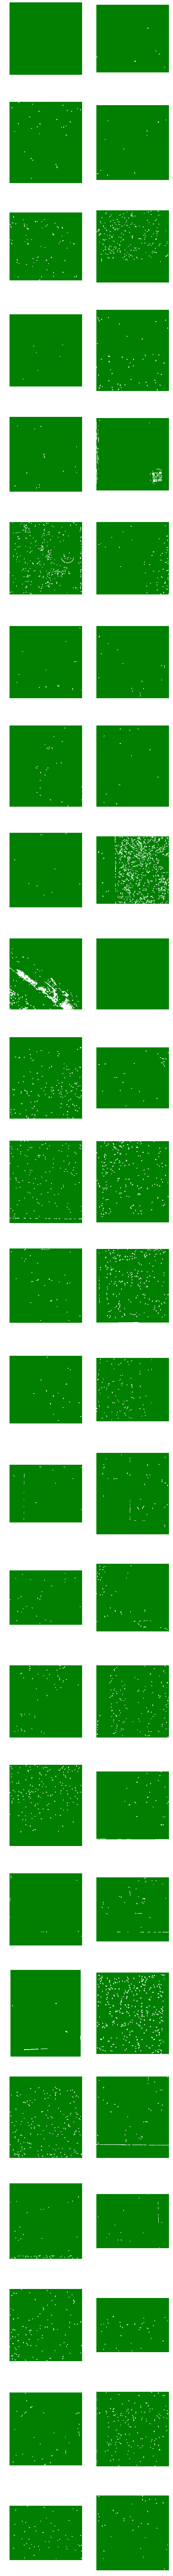

In [15]:
from scipy.ndimage import morphology

def varroa_thresholding(input_image):
    
    # Transforming the image to HSV format to find the mean of lightness of image
    image_hsv = cv2.cvtColor(input_image,cv2.COLOR_RGB2HSV)
    mean_hsv = np.mean(image_hsv[:,:,2])
    
    # Improving the lightness based on the mean lightness of the image (if it is not decent)
    if (mean_hsv <= 110):
        image_hsv[:,:,2] = image_hsv[:,:,2] *1.2
    elif(mean_hsv > 150):
        image_hsv[:,:,2] = image_hsv[:,:,2] *0.8
    #contrast limited histgram equalization
    # Performing an adaptive thresholding on the grayscale version of image
    image_rgb = cv2.cvtColor(image_hsv,cv2.COLOR_HSV2RGB)
    image_grayscale = cv2.cvtColor(image_rgb,cv2.COLOR_RGB2GRAY)
    clahe = cv2.createCLAHE(clipLimit=1.0, tileGridSize=(8,8))
    image_grayscale = clahe.apply(image_grayscale)
    image_thresholded= ~(cv2.adaptiveThreshold(image_grayscale,255,cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY,15,3))
    
    # Performing different morphological operations to improve the result
    image_processed = skimage.morphology.remove_small_objects(image_thresholded.astype(bool), min_size=250)
    image_processed = skimage.morphology.binary_opening(image_processed.astype(bool), selem = square(4), out=None)
    image_processed = skimage.morphology.binary_closing(image_processed.astype(bool), selem = square(5), out=None)
    image_processed = skimage.morphology.binary_erosion(image_processed.astype(bool), selem=np.ones([6,6]))
    image_processed = skimage.morphology.binary_dilation(image_processed.astype(bool), selem=np.ones([6,6]))
    image_processed = skimage.morphology.remove_small_objects(image_processed.astype(bool), min_size=170)
    image_processed = skimage.morphology.binary_opening(image_processed, selem = square(8), out=None)
    image_processed = morphology.binary_fill_holes(image_processed).astype(np.uint8)
    image_processed = skimage.morphology.remove_small_objects(image_processed.astype(bool), min_size=290)
    image_processed = skimage.morphology.binary_opening(image_processed.astype(bool), selem = square(6), out=None)
    image_processed = skimage.morphology.binary_closing(image_processed.astype(bool), selem = square(6), out=None)
    
    return image_processed

# Applying the thresholding function on the image collection
ic_thresholded=skimage.io.ImageCollection(image_test,load_func=varroa_thresholding)

# Plotting the thresholded image collection
fig, axes = plt.subplots(25, 2, figsize=(12, 200))
for ax, im in zip(axes.ravel(), ic_thresholded):
    ax.imshow(im,cmap='ocean')
    ax.axis('off')
plt.show()


----  T=0.3 -----


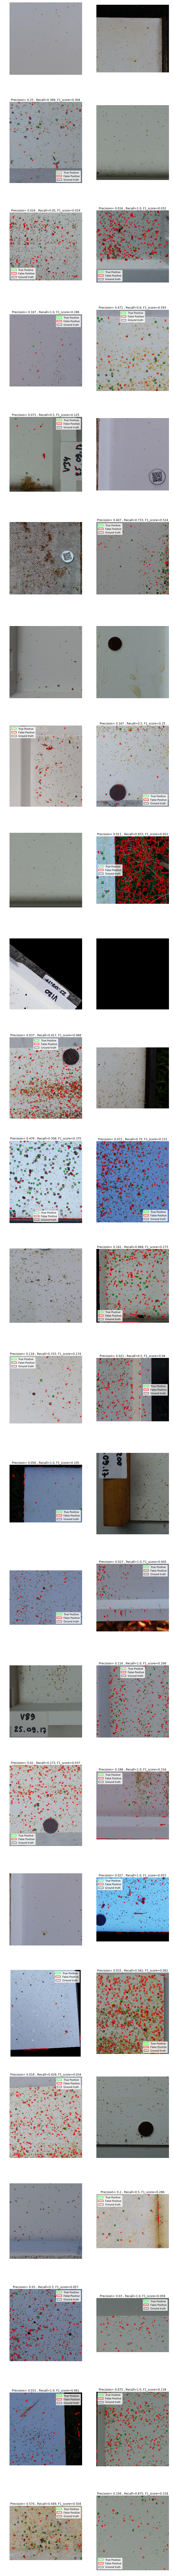

In [16]:
import matplotlib.patches as mpatches

# Function performs the labeling of varroas on the thresholded image
def varroa_labeling(image_processed):
    labels=skimage.measure.label(image_processed,neighbors=8,background=0,return_num=False)
    return labels
from math import sqrt

# Finds the distance between two points
def distance_finder(x_1,y_1,x_2,y_2):  
    dist = sqrt((x_2 - x_1)**2 + (y_2 - y_1)**2)  
    return dist 

# Finds the intersection over union of two rectangles
def intersection_over_union(rect_1, rect_2):
    x_1 = max(rect_1[0], rect_2[0])
    y_1 = max(rect_1[1], rect_2[1])
    x_2 = min(rect_1[2], rect_2[2])
    y_2 = min(rect_1[3], rect_2[3])

    rect_1_area = (rect_1[2] - rect_1[0] +1) * (rect_1[3] - rect_1[1] +1)
    rect_2_area = (rect_2[2] - rect_2[0] +1) * (rect_2[3] - rect_2[1] +1)
    intersection = max(0, x_2 - x_1 +1) * max(0, y_2 - y_1 +1)
    IoU = intersection / float(rect_1_area + rect_2_area - intersection)
    
    return IoU

# Applies the labeling function on the thresholded image
ic_labeled=skimage.io.ImageCollection(ic_thresholded,load_func=varroa_labeling)

# Finds precision, recall, and F1-score of each of the detected varroas based on the threshold
def Precision_Recall_F1_score(T):
    
    fig, axes = plt.subplots(25, 2, figsize=(12, 200))
    for ax, im, ig , annotations  in zip(axes.ravel(), image_test,ic_labeled, annotations_test):
        
        # Initializing the variables
        if len(annotations)>0:
            dist=[]
            true_positive=0
            false_positive=0
        
            for region_labeled in skimage.measure.regionprops(ig):
                # Check if the area of labeled region big enough
                if region_labeled.area >= 100: 
                    dist=[]
                    IoU=[]
                
                    # Checking each labeled region with all the ground truth regions 
                    # and find the one with the minimum distance
                        
                    for anno in annotations:
                        dist.append(distance_finder(region_labeled.centroid[1],region_labeled.centroid[0],(anno['bbox'][0]+(anno['bbox'][2])/2),(anno['bbox'][1]+(anno['bbox'][3])/2)))
                    least_distance=np.argmin(dist)
                
                    # Finding the intersection over union between the labeled area and the ground
                    # truth with the least distance
                    bbox_region_truth=annotations[least_distance]
                    IoU=intersection_over_union((bbox_region_truth['bbox'][0],bbox_region_truth['bbox'][1],bbox_region_truth['bbox'][0]+bbox_region_truth['bbox'][2],bbox_region_truth['bbox'][1]+bbox_region_truth['bbox'][3]),(region_labeled.bbox[1],region_labeled.bbox[0],region_labeled.bbox[3],region_labeled.bbox[2]))
                    del dist
                
                    # Implementing the decent text size and thickness based on the size of image
                    if im.size<200000:
                        text_size=0.35
                        text_thickness=1
                    elif im.size<600000:
                        text_size=0.6
                        text_thickness=2
                    elif im.size<1000000:
                        text_size=0.8
                        text_thickness=2
                    else: 
                        text_size=1
                        text_thickness=3
                    
                    # Patching the true positives with green rectangles and numbers
                    if (IoU>=T):
                        #cv2.putText(im,'{}%'.format(((int(IoU*100)))),(int(region_labeled.bbox[1] ),int(region_labeled.bbox[0]) -5),fontFace=cv2.FONT_HERSHEY_SIMPLEX,fontScale=text_size, color=(0, 255, 0),thickness=text_thickness)
                        y_min, x_min, y_max, x_max = region_labeled.bbox
                        rect_detection = mpatches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min,fill=False, edgecolor='lime', linewidth=1.5)
                        line_1=ax.add_patch(rect_detection)
                        # Counting the number of false positives
                        true_positive=true_positive+1
            
                    # Patching the false positives with red rectangles and numbers
                    else:
                        #cv2.putText(im,'{}%'.format(((int(IoU*100)))),(int(region_labeled.bbox[1] ),int(region_labeled.bbox[0]) -5),fontFace=cv2.FONT_HERSHEY_SIMPLEX,fontScale=text_size, color=(255, 0, 0),thickness=text_thickness)
                        y_min, x_min, y_max, x_max = region_labeled.bbox
                        rect_detection = mpatches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min,fill=False, edgecolor='red', linewidth=1.5)
                        line_2=ax.add_patch(rect_detection)
                        # Counting the number of false positives
                        false_positive=false_positive+1
            ax.imshow(im,cmap='ocean')
        
            # Finding the number of false negatives for each image
            false_negative=np.size(annotations)-true_positive
        
            # Finding the precision and recall for each of the figures
            if (false_positive+true_positive)==0:
                precision='XX'
            else:
                precision=true_positive/(false_positive+true_positive)
            #precision=true_positive/(false_positive+true_positive)
            if (false_negative+true_positive)==0:
                recall='XX'
            else:
                recall=true_positive/(false_negative+true_positive)
        
            # Finding the precision and recall for each of the figures
            # If we have a zero in the denominator of the F1_score function, the output will be XX
            if (precision+recall)==0 or precision=='XX' or recall=='XX':
                f1_score='XX'
            else:
                f1_score=(2*precision*recall)/(precision+recall)
        
            # Drawing the rectangles for the ground truth    
            for anno in annotations:
                    rect_ground_truth = patches.Rectangle((anno['bbox'][0], anno['bbox'][1]), anno['bbox'][2], anno['bbox'][3],
                    linewidth=1,edgecolor='black',facecolor='none')
                    line_3=ax.add_patch(rect_ground_truth) 


            # Adding the titles that contain the precision, recall and F1-score
                #ax.set_title("Precision= %s , Recall=%s, F1_score=%s" % (np.round(precision,3), np.round(recall,3), f1_score))
            if (f1_score)!='XX' and (recall)!='XX' and (precision)!='XX':
                ax.set_title("Precision= %s , Recall=%s, F1_score=%s" % (np.round(precision,3), np.round(recall,3), np.round(f1_score,3)))
        
            # Adding the legends
            if 'line_2' in locals() and 'line_1' in locals():
                ax.legend((line_1, line_2, line_3), ('True Positive','False Positive','Ground truth'))
            elif 'line_1' in locals():
                ax.legend((line_1, line_3), ('True Positive','Ground truth')) 
            elif 'line_2' in locals():
                ax.legend((line_2, line_3), ('False Positive','Ground truth')) 
            ax.axis('off') 
        else:
            ax.imshow(im,cmap='ocean')
            ax.axis('off')
            
    plt.show()
    return IoU

# Calling the function for the two different thresholds
T=0.3
print("----  T=%s -----" % (T) )
P=Precision_Recall_F1_score(T)

Add your implementation. Report the Precision, Recall and F1-score, by using all 50 images of the test-set, and considering 0.3 as the IoU threshold.

In [9]:
#Your code

## Part 2: Implement your first detector

Write your function(s) for the second part. Feel free to change the name of the function and add your additional functions, but please make sure their input and output follows the mentioned format.

In [10]:
def detect_by_method_1(img):
    '''
    Input: One single image
    Output: A numpy array containing coordonates of all detected varroas, with the following format: 
            [[x_1, y_1, w_1, h_2], [x_2, y_2, w_1, h_2], ..., [x_n, y_n, w_n, h_n]] 
            where ''n'' is the number of detected varroas.
    '''

    #Your code

Add your implementation. Report the Precision, Recall and F1-score, by using all 50 images of the test-set, and considering 0.3 as the IoU threshold.

In [11]:
#Your code

## Part 3: Using MLP and CNNs

Add your implementation for the thrid part. Feel free to add your desirable functions, but please make sure you have proper functions for the final detection, where their input and output follows the same format as the previous parts.

In [12]:
#Your code

## Challenge

You can generate a json submission file by using the function ''**generate_pred_json**''. This prediction file can be uploaded online for evaluation (Please refer to section 3 of the project description for more details).

In [13]:
import numpy as np
import json

def generate_pred_json(data, tag='baseline'):
    '''
    Input
    - data: Is a dictionary d, such that:
          d = { 
              "ID_1": [], 
              "ID_2": [[x_21, y_21, w_21, h_21], [x_22, y_22, w_22, h_22]], 
              ... 
              "ID_i": [[x_i1, y_i1, w_i1, h_i1], ..., [x_iJ, y_iJ, w_iJ, h_iJ]],
              ... 
              "ID_N": [[x_N1, y_N1, w_N1, h_N1]],
          }
          where ID is the string id of the image (e.i. 5a05e86fa07d56baef59b1cb_32.00px_1) and the value the Kx4 
          array of intergers for the K predicted bounding boxes (e.g. [[170, 120, 15, 15]])
    - tag: (optional) string that will be added to the name of the json file.
    Output
      Create a json file, "prediction_[tag].json", conatining the prediction to EvalAI format.
    '''
    unvalid_key = []
    _data = data.copy()
    for key, value in _data.items():
        try:
            # Try to convert to numpy array and cast as closest int
            print(key)
            v = np.around(np.array(value)).astype(int)
            # Check is it is a 2d array with 4 columns (x,y,w,h)
            if v.ndim != 2 or v.shape[1] != 4:
                unvalid_key.append(key)
            # Id must be a string
            if not isinstance(key, str):
                unvalid_key.append(key)
            _data[key] = v.tolist()
        # Deal with not consistant array size and empty predictions
        except (ValueError, TypeError):
            unvalid_key.append(key)
    # Remove unvalid key from dictionnary
    for key in unvalid_key: del _data[key]
    
    with open('prediction_{}.json'.format(tag), 'w') as outfile:
        json.dump(_data, outfile)

In [14]:
#Your code